# Supermarket Case Study: Market Basket Analysis for Coffee Shop

A supermarket store named Big Mart has opened a coffee shop inside the premises and after the launch it started seeing great traction and it was decided to have similar coffee shops at all the stores across the region for Big Mart. Big Mart has been using association rules for its main retail stores and under the marketing plan for these coffee shops, they want to create similar association rules and do combo offers for these shops

Transaction data for the coffee shop relating to 9000+ purchases was collected. The task is to find out the top association rules for the product team to create combo offers and use the insights to make the coffee shop even more profitable at all these stores.



## Table of Content

[1. Reading Dataset](#Reading-Dataset)

[2. Basic Exploration](#explore)

[3.Importing mlxtend library](#mlxtend)

[4. Preprocessing Dataset for mining association rules using mlextend](#preprocess)

[5. Finding Frequent Itemsets with given support threshold using apriori](#apriori)

[6. Finding top association rules with Lift & Confidence as metrics](#lift)

[7. Conclusions](#conclusions)

## 1. Reading Dataset <a class="anchor" id="Reading-Dataset"></a>

In [1]:
import pandas as pd
import numpy as np
#import warnings
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
#warnings.filterwarnings('ignore')

In [2]:
# Reading the transactions from csv file
df = pd.read_csv('coffeeshop_transactions.csv')

## 2. Basic Exploration <a class="anchor" id="explore"></a>

In [3]:
# Eyeballing a sample of the dataset
df.head(10)

,Date,Time,Transaction,Item
0,30/10/16,9:58:11,1,Bread
1,30/10/16,10:05:34,2,Scandinavian
2,30/10/16,10:05:34,2,Scandinavian
3,30/10/16,10:07:57,3,Hot chocolate
4,30/10/16,10:07:57,3,Jam
5,30/10/16,10:07:57,3,Cookies
6,30/10/16,10:08:41,4,Muffin
7,30/10/16,10:13:03,5,Coffee
8,30/10/16,10:13:03,5,Pastry
9,30/10/16,10:13:03,5,Bread


Here what we see is there is date and time of each transaction with a transaction id in the column called transaction. We see that transaction 1 just has 1 item bread while transaction 2 has 2 scandinavians and transaction 3 has 3 different items.

### Checking for missing values

In [4]:
#Checking the number of purchases and missing values
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21286 entries, 0 to 21285
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21286 non-null  object
 1   Time         21286 non-null  object
 2   Transaction  21286 non-null  int64 
 3   Item         21286 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.3+ KB


((21286, 4), None)

Clearly, there are no missing values here which is great!

### Listing all the items in the dataset

In [5]:
#Number of unique Items
df['Item'].nunique()

93

In [6]:
# Checking the list of items in the dataset
df['Item'].unique()

array(['Bread', 'Scandinavian', 'Hot chocolate', 'Jam', 'Cookies',
       'Muffin', 'Coffee', 'Pastry', 'Medialuna', 'Tea', 'NONE',
       'Tartine', 'Mineral water', 'Farm House', 'Fudge', 'Juice',
       "Ella's Kitchen Pouches", 'Victorian Sponge', 'Frittata',
       'Hearty & Seasonal', 'Soup', 'Pick and Mix Bowls', 'Smoothies',
       'Cake', 'Mighty Protein', 'Chicken sand', 'Coke',
       'My-5 Fruit Shoot', 'Focaccia', 'Sandwich', 'Alfajores', 'Eggs',
       'Brownie', 'Dulce de Leche', 'Honey', 'The BART', 'Granola',
       'Fairy Doors', 'Empanadas', 'Keeping It Local', 'Art Tray',
       'Bowl Nic Pitt', 'Bread Pudding', 'Truffles', 'Chimichurri Oil',
       'Bacon', 'Spread', 'Kids biscuit', 'Siblings', 'Caramel bites',
       'Jammie Dodgers', 'Tiffin', 'Olum & polenta', 'Polenta',
       'The Nomad', 'Hack the stack', 'Bakewell', 'Lemon and coconut',
       'Toast', 'Scone', 'Crepes', 'Vegan mincepie', 'Bare Popcorn',
       'Muesli', 'Crisps', 'Pintxos', 'Gingerbread syr

We have total of 93 items with one of the item being 'NONE'. Let's check how many rows have 'NONE' as item

In [7]:
#Check how many rows have none as an item
x = df['Item'] == "NONE"
print(x.value_counts())

False    20500
True       786
Name: Item, dtype: int64


So there are 786 transactions with none which is quite small wrt the database so it would be best to get rid of all these rows.

### Dropping all none values from the dataframe

In [8]:
#Dropping rows with NONE as the item
df = df.drop(df[df.Item == 'NONE'].index)

Now, given that this is taken care of, lets check the 20 top selling items for the coffee shop.

### Top 20 best selling items for the coffee shop

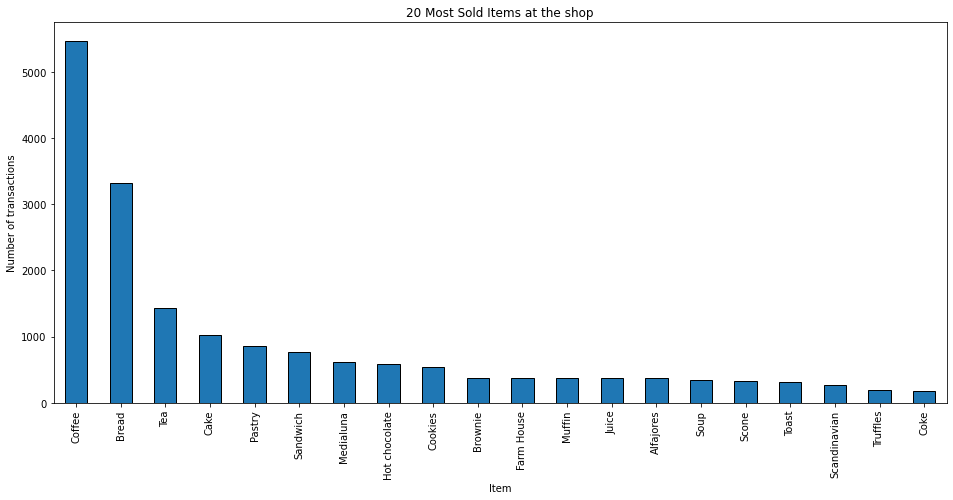

In [9]:
fig, ax=plt.subplots(figsize=(16,7))
df['Item'].value_counts().sort_values(ascending=False).head(20).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=1)
plt.xlabel('Item')
plt.ylabel('Number of transactions')
plt.title('20 Most Sold Items at the shop')
plt.show()

1. Around 48% of transactions contains `coffee`, 33% contains `bread`, 14% contains `tea` and 10% contains `cake`.
2. Together coffee and bread 9%, coffee and tea 5%, coffee and cake 5%, bread and tea 3%, bread and cake 2%, tea and cake 2%.

## 3.Importing MLxtend library <a class="anchor" id="mlxtend"></a>

For using apriori algorithm and extracting association rules, we will import apriori and association rules module from mlxtend.frequent patterns

In [10]:
#Importing required modules from mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [11]:
df.groupby(['Transaction', 'Item'])['Item'].count().unstack().fillna(0)

Item,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Bowl Nic Pitt,Bread,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to use apriori algorithm and find out the relevant association rules, we need to convert the transactions into user item matrix such that each column is an item and each value in the matrix is 1 if an item belongs to a transaction and 0 if an item does not belong to a transaction

## 4. Preprocessing Dataset for mining association rules using mlxtend <a class="anchor" id="preprocess"></a>
For applying apriori algorithm from mlxtend library, we need to first convert this into a format where all the items are as columns and filled with 1 if an item is in the transaction and 0 otherwise

In [12]:
#First step is to group it by transaction id and item to find item count in each transaction
df.groupby(['Transaction', 'Item'])['Item'].count()

Transaction  Item         
1            Bread            1
2            Scandinavian     2
3            Cookies          1
             Hot chocolate    1
             Jam              1
                             ..
9682         Tacos/Fajita     1
             Tea              1
9683         Coffee           1
             Pastry           1
9684         Smoothies        1
Name: Item, Length: 18880, dtype: int64

In [13]:
#To get each item in a separate column, we can use unstack
df.groupby(['Transaction', 'Item'])['Item'].count().unstack().head()

Item,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Bowl Nic Pitt,Bread,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Fill the missing values with 0 meaning that item is not there in a transaction
df.groupby(['Transaction', 'Item'])['Item'].count().unstack().fillna(0)

Item,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Bowl Nic Pitt,Bread,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#Finally you can store the result separately
hot_encoded_df = df.groupby(['Transaction', 'Item'])['Item'].count().unstack().fillna(0)
hot_encoded_df

Item,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Bowl Nic Pitt,Bread,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to implement apriori algorithm we don't need the count of each item, for example in transaction 2 we saw 2 scandinavians but in order to identify association just a 1 or 0 is enough. We will define a function to say everything greater than 1 will be changed to 1

In [16]:
#Function to change all the values greater than or equal to 1 as just 1 and others to be 0
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Applying the function to the encoded dataframe
hot_encoded_df = hot_encoded_df.applymap(encode_units)

## 5. Finding Frequent Itemsets with given support threshold <a class="anchor" id="apriori"></a>

We will use Apriori Algorithm to find the rules with a support threshold of 0.01 or 1%. 

In [17]:
# using the 'apriori algorithm' with min_support=0.01 (1% of 9465)
# It means the item should be present in atleast 94 transaction out of 9465 transactions only when we considered that item in
# frequent itemset

frequent_itemsets = apriori(hot_encoded_df, min_support = 0.01, use_colnames = True)
frequent_itemsets

c:\Users\divyansh\anaconda3\envs\tensor\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


,support,itemsets
0,0.036352,(Alfajores)
1,0.016063,(Baguette)
2,0.327275,(Bread)
3,0.040051,(Brownie)
4,0.103878,(Cake)
...,...,...
56,0.023671,"(Toast, Coffee)"
57,0.014372,"(Sandwich, Tea)"
58,0.010039,"(Bread, Cake, Coffee)"
59,0.011202,"(Pastry, Bread, Coffee)"


We see that the top support is for coffee and bread, then coffee and pastry and some other combinations including coffee necessarily which was expected as coffee in itself has the highest support.

We have used apriori algorithm to find all items with top support values to prevent items that are uninteresting from a business point of view on account of being really rare are removed and now the next step is to measure the reliability of the inference made by the rule, we will check for confidence and lift for all these itemsets.

## 6. Finding top association rules with Lift & Confidence as the metrics <a class="anchor" id="lift"></a>

Now once we have identified the frequent itemsets using apriori algorithm, we can now calculate various parameters for the same such as lift and confidence to see which of the rules can be really established as most important ones

In [18]:
# now making the rules from frequent itemset generated above
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)
rules.sort_values('confidence', ascending = False, inplace = True)
rules[['antecedents','consequents','support','confidence','lift']].head(5)

,antecedents,consequents,support,confidence,lift
30,(Toast),(Coffee),0.023671,0.704403,1.472120
29,(Spanish Brunch),(Coffee),0.010884,0.598837,1.251501
18,(Medialuna),(Coffee),0.035190,0.569231,1.189627
22,(Pastry),(Coffee),0.047554,0.552147,1.153924
0,(Alfajores),(Coffee),0.019656,0.540698,1.129996


### How to read the table?</font>
Let us consider the first row of the table. 
>It can be read as `Toast → Coffee` {antecedents → consequents}
>>It stated that **if Toast then Coffee** which means when Toast is ordered people also ordered Coffee and to support this statement we have *confidence* and *lift* which are 0.70 and 1.47 respectively which are very good.

- *antecedents*: It is an item (here toast) who support the other item (coffee).
- *consequents*: It is an item (here coffee) who is supported by the an item (toast).
- *support*: Support of an both antecedent and consequent. It states that 2.37% of transactions contain both toast and coffee.
- *confidence*: A confidence of 0.7 would mean that in 70% of the cases where toast were purchased, the purchase also included coffee.
- *lift*: Lift of greater than 1 means products A and B are more likely to be bought together. Here lift of 1.47 means the likelihood of a customer buying both toast and coffee together is 1.47 times more than the chance of purchasing coffee alone.

## 7. Conclusions
On the basis of high confidence (considered greater than or equal to 0.55), we have the following rules:
- toast → coffee
- spanish brunch → coffee 
- medialuna → coffee
- pastry → coffee

A very important thing to note here is that association rules should be interpreted with caution and they do not necessarily imply causality. Instead they suggest strong co-occurance relationship between items.